In [21]:
! pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 137.6 MB/s eta 0:00:00


In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:07<00:00, 142MB/s] 

Extracting files...


Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [3]:
path = '/home/ec2-user/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
data = pd.read_csv(path + '/captions.txt')

In [63]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


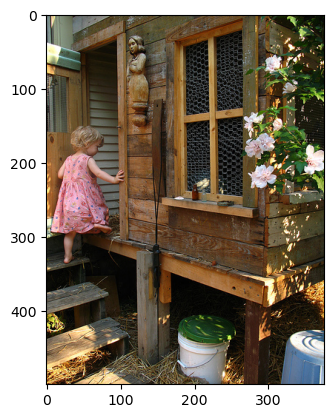

In [7]:
plt.imshow(plt.imread(path + '/Images/1000268201_693b08cb0e.jpg'))

## Text preprocessing
I follow the following steps to preprocess the captions:
1. Make all characters lowercase and remove the punctuation (and other special characters).
2. Tokenize the characters.
3. Build a vocabulary by assigning an ID to each number.

Make sure to include special token, such as \<start\>, \<end\> and \<pad\> to mark the start, end of a caption and to make all captions of same length by padding it with pad tokens.

In [8]:
captions = data['caption'].to_list()
print(len(captions))

40455


In [9]:
import re
from collections import Counter

#nlp = spacy.load("en_core_web_sm")

print(captions[:5])

def make_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

captions = [ make_lowercase(caption) for caption in captions ]
captions = [ remove_punctuation(caption) for caption in captions ]

print(captions[:5])

# Tokenize with spaCy, make sure to add the start and end tokens
def tokenize_spacy(captions):
    tokenized = []
    
    for doc in nlp.pipe(captions, batch_size=1000, n_process=-1):
        tokenized.append( ['<start>'] + [ token.text for token in doc ] + ['<end>'] )
    
    return tokenized
    #return ['<start>'] + [ token.text for token in nlp(text) ] + ['<end>']

def tokenize_basic(text):
    tokens = text.strip().split() # clean whitespaces
    return ['<start>'] + tokens + ['<end>']

tokenized = [tokenize_basic(caption) for caption in captions]
print(tokenized[:5])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
['a child in a pink dress is climbing up a set of stairs in an entry way ', 'a girl going into a wooden building ', 'a little girl climbing into a wooden playhouse ', 'a little girl climbing the stairs to her playhouse ', 'a little girl in a pink dress going into a wooden cabin ']
[['<start>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>'], ['<start>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '<end>'], ['<start>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '<end>'], ['<start>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '<end>'], ['<start>', 'a

In [10]:
def create_vocab(tokenized_captions, specials):
    counter = Counter()

    # Note: this doesn't work with a set!
    for tokens in tokenized:
        counter.update(tokens)

    seen_words = [ word for word in counter.keys() if word not in specials ]

    vocab_to_idx = { word: (idx + len(specials)) for idx, word in enumerate(seen_words) }
    vocab_to_idx = dict(vocab_to_idx, **{ special_token: idx for idx, special_token in enumerate(specials) })


    idx_to_vocab = { idx: word for word, idx in vocab_to_idx.items() }

    return vocab_to_idx, idx_to_vocab

specials = ['<pad>', '<start>', '<end>', '<unk>']

vocab_to_idx, idx_to_vocab = create_vocab(tokenized, specials)
vocab_len = len(vocab_to_idx)
print(vocab_len)

8832


In [11]:
def tokens_to_idx(tokenized_caption, vocab_to_idx):
    return [ vocab_to_idx[token] for token in tokenized_caption ]

captions_idx = [ tokens_to_idx(caption, vocab_to_idx) for caption in tokenized ]

def pad_captions(captions_idx, pad_token_index=0):
    max_len = max([ len(caption) for caption in captions_idx ])

    for caption in captions_idx:
        while len(caption) < max_len:
            caption.append(pad_token_index)

    return captions_idx

captions_idx = pad_captions(captions_idx, 0)
captions_idx = np.array(captions_idx)

In [12]:
print(captions_idx.shape)

(40455, 38)


In [22]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [23]:
import torch
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu_score_sum(outputs, targets):
    sum = 0.0

    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()

    for output, target in zip(outputs, targets):
        output = [ idx_to_vocab[idx] for idx in output if idx not in [0,1,2,3] ] # exclude <pad>, <start>, <end>, <unk>
        target = [ idx_to_vocab[idx] for idx in target if idx not in [0,1,2,3] ] # exclude <pad>, <start>, <end>, <unk>

        #print(output, target)

        smooth_fn = SmoothingFunction()

        sum += sentence_bleu(references=[ target ], hypothesis=output, smoothing_function=smooth_fn.method1)

    return sum

In [24]:
def generate_caption(model, image, vocab_to_idx, max_len, device='cuda'):
    model.eval()

    with torch.no_grad():
        image = image.unsqueeze(0) # shape: (1, C, H, W)
        caption = [ vocab_to_idx['<start>'] ]
        
        for _ in range(max_len - 1):
            input_seq = torch.tensor(caption).unsqueeze(0).to(device)  # (1, seq_len)

            outputs = model(image, input_seq)  # (1 * seq_len, vocab_size)
            next_token = outputs[-1].argmax().item()

            caption.append(next_token)

            if next_token == vocab_to_idx['<end>']:
                break
        
        while len(caption) < max_len:
            caption.append(vocab_to_idx['<pad>'])

    return caption

In [25]:
def eval(model, test_loader, device):
    model.eval()

    total_bleu_score = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, target_captions in test_loader:
            images, target_captions = images.to(device), target_captions.to(device)

            output_captions = []

            for img_idx in range(images.size(0)):
                caption = generate_caption(model, images[img_idx], vocab_to_idx, 38, device)
                
                output_captions.append(caption)

            output_captions = torch.tensor(output_captions).to(device)

            total_bleu_score += bleu_score_sum(output_captions, target_captions)
            total_samples += images.size(0)
    
    avg_bleu_score = total_bleu_score / total_samples
    print(f"Test BLEU Score: {avg_bleu_score:.4f}")

def train(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=5):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()

        total_loss = 0.0
        total_samples = 0

        for images, captions in train_loader:
            images, captions = images.to(device), captions.to(device)

            inputs = captions[:, :-1] # inputs to the RNN, the last one is the final output
            targets = captions[:, 1:] # targets for the outputs of the RNN (ie start from the 2nd word)

            optimizer.zero_grad()

            outputs = model(images, inputs) # (B * seq_len-1, vocab_size)

            loss = criterion(outputs, targets.contiguous().view(-1))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_samples += images.size(0)

        avg_loss = total_loss / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

        eval(model, test_loader, device)

In [26]:
'''
# !!! OLD !!!
def eval(model, test_loader, criterion, device):
    model.eval()

    total_loss = 0.0
    total_bleu_score = 0.0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, captions in test_loader:
            images, captions = images.to(device), captions.to(device)

            inputs = torch.zeros_like(captions[:, :-1]) # masked out inputs, pad_idx is 0
            targets = captions[:, 1:]

            outputs = model(images, inputs) # (B * seq_len-1, vocab_size)
            outputs = outputs.view(len(images), -1, outputs.size(-1)) # (B, seq_len-1, vocab_size)

            output_tokens = torch.argmax(outputs, axis=2)

            total_bleu_score += bleu_score_sum(output_tokens, targets)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.contiguous().view(-1))

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    avg_bleu_score = total_bleu_score / len(test_loader)

    print(f"BLEU Score: {avg_bleu_score:.4f}")
    print(f"Test Loss: {avg_loss:.4f}")

def train(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=5):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for images, captions in train_loader:
            images, captions = images.to(device), captions.to(device)

            inputs = captions[:, :-1] # inputs to the RNN, the last one is the final output
            targets = captions[:, 1:] # targets for the outputs of the RNN (ie start from the 2nd word)

            optimizer.zero_grad()

            outputs = model(images, inputs) # (B * seq_len-1, vocab_size)

            loss = criterion(outputs, targets.contiguous().view(-1))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        eval(model, test_loader, criterion, device)
'''

'\n# !!! OLD !!!\ndef eval(model, test_loader, criterion, device):\n    model.eval()\n\n    total_loss = 0.0\n    total_bleu_score = 0.0\n\n    criterion = torch.nn.CrossEntropyLoss()\n\n    with torch.no_grad():\n        for images, captions in test_loader:\n            images, captions = images.to(device), captions.to(device)\n\n            inputs = torch.zeros_like(captions[:, :-1]) # masked out inputs, pad_idx is 0\n            targets = captions[:, 1:]\n\n            outputs = model(images, inputs) # (B * seq_len-1, vocab_size)\n            outputs = outputs.view(len(images), -1, outputs.size(-1)) # (B, seq_len-1, vocab_size)\n\n            output_tokens = torch.argmax(outputs, axis=2)\n\n            total_bleu_score += bleu_score_sum(output_tokens, targets)\n            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.contiguous().view(-1))\n\n            total_loss += loss.item()\n\n    avg_loss = total_loss / len(test_loader)\n    avg_bleu_score = total_bleu_score /

In [27]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, captions_tokenized, root_dir, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_captions_data = data
        self.captions_tokenized = captions_tokenized
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.captions_tokenized)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        caption = self.captions_tokenized[idx]

        img_path = os.path.join(self.root_dir,
                                self.image_captions_data.iloc[idx, 0])

        image = io.imread(img_path)
        #image = torch.from_numpy(image)

        if self.transform:
            image = self.transform(image)

        return [ image, caption ]

In [29]:
def create_loaders(captions_df, captions_idx, image_path):
    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
    ])

    caption_dset = ImageCaptionDataset(captions_df, captions_idx, root_dir=image_path, transform=image_transforms)
    train_dset, test_dset = random_split(caption_dset, [0.8, 0.2])

    train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dset, batch_size=32, shuffle=True, num_workers=0)

    return train_loader, test_loader

In [30]:
from torch.utils.data import random_split

In [31]:
image_path = path + '/Images'

train_loader, test_loader = create_loaders(data, captions_idx, image_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # ignore the pad_idx!!

In [33]:
from datetime import datetime

## Experiment 1

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCaptionModel(nn.Module):
    def __init__(self, vocab_size):#, embed_dim, hidden_dim, output_dim, model_name):
        super(SimpleCaptionModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),  # (B, 8, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),  # (B, 8, 56, 56)
        )

        self.fc1 = nn.Linear(8 * 56 * 56, 256)  # (B, 256)

        self.embed = nn.Embedding(vocab_size, 256)

        self.rnn = nn.LSTM(input_size=256, hidden_size=256, num_layers=1, batch_first=True)  # (B, seq_len, 256)

        self.fc2 = nn.Linear(256, vocab_size)  # (B, seq_len, vocab_size)
    
    def forward(self, images, captions):
        # images: (B, 3, 224, 224)
        # captions: (B, seq_len=38)

        F = self.cnn(images) # (B, 8, 56, 56)
        F = F.view(F.size(0), -1) # (B, 8*56*56)

        rnn_hidden = nn.Tanh()(self.fc1(F)) # (B, 256)
        rnn_input = self.embed(captions)  # (B, seq_len, 256)

        rnn_out, _ = self.rnn(rnn_input, (rnn_hidden.unsqueeze(0), torch.zeros_like(rnn_hidden).unsqueeze(0))) # (B, seq_len, 256)

        rnn_out = rnn_out.contiguous().view(-1, rnn_out.size(-1))  # Flatten the output for the fully connected layer
        logits = self.fc2(rnn_out)  # (B * seq_len, vocab_size)

        #logits = self.fc2(rnn_out)  # (B, seq_len, vocab_size)

        return logits

In [26]:
start = datetime.now()

model1 = SimpleCaptionModel(
    vocab_size=8832,
)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

train(
    model=model1,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer1,
    criterion=criterion,
    device=device,
    num_epochs=10
)

end = datetime.now()

print(end - start)

Epoch [1/10], Train Loss: 0.1257
Test BLEU Score: 0.0318
Epoch [2/10], Train Loss: 0.1036
Test BLEU Score: 0.0296
Epoch [3/10], Train Loss: 0.0956
Test BLEU Score: 0.0303
Epoch [4/10], Train Loss: 0.0898
Test BLEU Score: 0.0276
Epoch [5/10], Train Loss: 0.0850
Test BLEU Score: 0.0284
Epoch [6/10], Train Loss: 0.0809
Test BLEU Score: 0.0265
Epoch [7/10], Train Loss: 0.0772
Test BLEU Score: 0.0170
Epoch [8/10], Train Loss: 0.0739
Test BLEU Score: 0.0318
Epoch [9/10], Train Loss: 0.0709
Test BLEU Score: 0.0268
Epoch [10/10], Train Loss: 0.0683
Test BLEU Score: 0.0318
0:54:14.440591


In [42]:
torch.save(model1, './model1.pth')

# The model, on every input image, it outputs: 
# ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'mountain']


## Experiment 2

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CaptionModel(nn.Module):
    def __init__(self, cnn_model, rnn_model, vocab_size, embed_dim):
        super(CaptionModel, self).__init__()

        self.cnn_model = cnn_model
        self.rnn_model = rnn_model

        self.cnn_output_dim = cnn_model.output_dim

        self.hidden_dim = rnn_model.hidden_size # output_dim same
        self.rnn_num_layers = rnn_model.num_layers

        self.embedding = nn.Embedding(vocab_size, embed_dim)


        self.fc_h0 = nn.Linear(self.cnn_output_dim, self.hidden_dim * self.rnn_num_layers)  # (B, channel * width * height) -> (B, rnn_input_dim)
        self.fc_c0 = nn.Linear(self.cnn_output_dim, self.hidden_dim * self.rnn_num_layers)  # (B, channel * width * height) -> (B, rnn_input_dim)

        self.tanh = nn.Tanh()
        
        self.fc_final = nn.Linear(self.hidden_dim, vocab_size) # (B * seq_length, rnn_input_dim) -> (B * seq_length, vocab_size)

    def forward(self, images, captions):
        F = self.cnn_model(images) # extracted features of dim (B, cnn_out_dim, W, H)
        F = F.view(F.size(0), -1)

        rnn_hidden_h0 = self.tanh(self.fc_h0(F))
        rnn_hidden_h0 = rnn_hidden_h0.view(self.rnn_num_layers, -1, self.hidden_dim)  # (B, num_layers, rnn_hidden_dim)

        rnn_hidden_c0 = self.tanh(self.fc_c0(F))
        rnn_hidden_c0 = rnn_hidden_c0.view(self.rnn_num_layers, -1, self.hidden_dim)  # (B, num_layers, rnn_hidden_dim)

        rnn_input = self.embedding(captions)

        rnn_out, _ = self.rnn_model(rnn_input, (rnn_hidden_h0, rnn_hidden_c0))  # (B, seq_len, rnn_input_dim)
        rnn_out = rnn_out.contiguous().view(-1, rnn_out.size(-1))  # Flatten the output for the fully connected layer

        logits = self.fc_final(rnn_out)  # (B * seq_len, vocab_size)
        return logits

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN3Layer(nn.Module):
    def __init__(self, input_channels=3, output_dim=256):
        super(CNN3Layer, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(32)

        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4) # (B, 32, 56, 56)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=4) # (B, 64, 14, 14)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.bn3 = nn.BatchNorm2d(64) # (B, 64, 14, 14)

        self.output_dim = 64 * 14 * 14
    
    def forward(self, x):
        x = self.bn1(self.relu1(self.conv1(x)))
        x = self.pool1(x)

        x = self.bn2(self.relu2(self.conv2(x)))
        x = self.pool2(x)

        x = self.bn3(self.relu3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten the output for the RNN

        return x


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

lstm512_3layer = nn.LSTM(input_size=512, hidden_size=512, num_layers=3, batch_first=True)


In [30]:
start = datetime.now()

model2 = CaptionModel(
    cnn_model=CNN3Layer(),
    rnn_model=lstm512_3layer,
    vocab_size=8832,
    embed_dim=512
)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

train(
    model=model2,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer2,
    criterion=criterion,
    device=device,
    num_epochs=30
)

end = datetime.now()

print(end - start)

Epoch [1/30], Train Loss: 0.1301
Test BLEU Score: 0.0278
Epoch [2/30], Train Loss: 0.1059
Test BLEU Score: 0.0318
Epoch [3/30], Train Loss: 0.0973
Test BLEU Score: 0.0099
Epoch [4/30], Train Loss: 0.0911
Test BLEU Score: 0.0270
Epoch [5/30], Train Loss: 0.0858
Test BLEU Score: 0.0267
Epoch [6/30], Train Loss: 0.0809
Test BLEU Score: 0.0268
Epoch [7/30], Train Loss: 0.0763
Test BLEU Score: 0.0270
Epoch [8/30], Train Loss: 0.0720
Test BLEU Score: 0.0263
Epoch [9/30], Train Loss: 0.0680
Test BLEU Score: 0.0193
Epoch [10/30], Train Loss: 0.0643
Test BLEU Score: 0.0284
Epoch [11/30], Train Loss: 0.0610
Test BLEU Score: 0.0308
Epoch [12/30], Train Loss: 0.0579
Test BLEU Score: 0.0270
Epoch [13/30], Train Loss: 0.0551
Test BLEU Score: 0.0270
Epoch [14/30], Train Loss: 0.0526
Test BLEU Score: 0.0234
Epoch [15/30], Train Loss: 0.0503
Test BLEU Score: 0.0219
Epoch [16/30], Train Loss: 0.0482
Test BLEU Score: 0.0214
Epoch [17/30], Train Loss: 0.0464
Test BLEU Score: 0.0269
Epoch [18/30], Train Lo

In [38]:
torch.save(model2, './model2.pth')

# ['a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'blue', 'hat', 'is', 'speaking']

## Experiment 3

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ResNet18FeatureExtractor(nn.Module):
    def __init__(self, pretrained=False):
        super(ResNet18FeatureExtractor, self).__init__()
        self.resnet18 = resnet18(pretrained=pretrained)
        self.resnet18.fc = self.resnet18.avgpool = nn.Identity()  # Remove the final fully connected layer

        self.output_dim = 512 * 49  # I guess the final layer (layer4) feature output has 512 channels and is 7*7

    def forward(self, x):
        x = self.resnet18(x)

        #print(x.shape)
        return x

In [39]:
lstm1024_5layer = nn.LSTM(input_size=1024, hidden_size=1024, num_layers=5, batch_first=True)

In [ ]:
model3 = CaptionModel(
    cnn_model=ResNet18FeatureExtractor(pretrained=False),
    rnn_model=lstm1024_5layer,
    vocab_size=8832,
    embed_dim=1024
)

optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)

start = datetime.now()

train(
    model=model3,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer3,
    criterion=criterion,
    device=device,
    num_epochs=15
)

end = datetime.now()

print(end - start)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/15], Train Loss: 0.1325
Test BLEU Score: 0.0320
Epoch [2/15], Train Loss: 0.1115
Test BLEU Score: 0.0093
Epoch [3/15], Train Loss: 0.1039
Test BLEU Score: 0.0275
Epoch [4/15], Train Loss: 0.0986
Test BLEU Score: 0.0319
Epoch [5/15], Train Loss: 0.0942
Test BLEU Score: 0.0208
Epoch [6/15], Train Loss: 0.0904
Test BLEU Score: 0.0272
Epoch [7/15], Train Loss: 0.0869
Test BLEU Score: 0.0293
Epoch [8/15], Train Loss: 0.0838
Test BLEU Score: 0.0308
Epoch [9/15], Train Loss: 0.0808
Test BLEU Score: 0.0316
Epoch [10/15], Train Loss: 0.0781
Test BLEU Score: 0.0251
Epoch [11/15], Train Loss: 0.0755


In [ ]:
# Above: whole session 12 hours total or so??

In [1]:
torch.save(model3, './model3.pth')

NameError: name 'torch' is not defined

# Experiment 4

In [40]:
frozen_resnet18 = ResNet18FeatureExtractor(pretrained=True)

for param in frozen_resnet18.parameters():
    param.requires_grad = False


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [ ]:
model4 = CaptionModel(
    cnn_model=frozen_resnet18,
    rnn_model=lstm1024_5layer,
    vocab_size=8832,
    embed_dim=1024
)

optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.001)

start = datetime.now()

train(
    model=model4,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer4,
    criterion=criterion,
    device=device,
    num_epochs=25
)

end = datetime.now()

print(end - start)

Epoch [1/25], Train Loss: 0.1324
Test BLEU Score: 0.0262
Epoch [2/25], Train Loss: 0.1100
Test BLEU Score: 0.0321
Epoch [3/25], Train Loss: 0.1011
Test BLEU Score: 0.0281
Epoch [4/25], Train Loss: 0.0946
Test BLEU Score: 0.0237
Epoch [5/25], Train Loss: 0.0893
Test BLEU Score: 0.0287
Epoch [6/25], Train Loss: 0.0845
Test BLEU Score: 0.0327
Epoch [7/25], Train Loss: 0.0800
Test BLEU Score: 0.0258
Epoch [8/25], Train Loss: 0.0757
Test BLEU Score: 0.0266
Epoch [9/25], Train Loss: 0.0716
Test BLEU Score: 0.0302
Epoch [10/25], Train Loss: 0.0678
Test BLEU Score: 0.0263
Epoch [11/25], Train Loss: 0.0641
Test BLEU Score: 0.0264


In [39]:
model5 = CaptionModel(
    cnn_model=frozen_resnet18,
    rnn_model=lstm1024_5layer,
    vocab_size=8832,
    embed_dim=1024
)

optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.0001)

start = datetime.now()

train(
    model=model5,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer5,
    criterion=criterion,
    device=device,
    num_epochs=10
)

end = datetime.now()

print(end - start)

Epoch [1/10], Train Loss: 0.1344
Test BLEU Score: 0.0309
Epoch [2/10], Train Loss: 0.1126
Test BLEU Score: 0.0324
Epoch [3/10], Train Loss: 0.1055
Test BLEU Score: 0.0292
Epoch [4/10], Train Loss: 0.1005
Test BLEU Score: 0.0278
Epoch [5/10], Train Loss: 0.0963
Test BLEU Score: 0.0284
Epoch [6/10], Train Loss: 0.0925
Test BLEU Score: 0.0201
Epoch [7/10], Train Loss: 0.0891
Test BLEU Score: 0.0299
Epoch [8/10], Train Loss: 0.0858
Test BLEU Score: 0.0317
Epoch [9/10], Train Loss: 0.0826
Test BLEU Score: 0.0299
Epoch [10/10], Train Loss: 0.0797
Test BLEU Score: 0.0281
2:59:07.749404


In [ ]:
# eval2(model5, test_loader, device)

# ['a', 'man', 'in', 'a', 'black', 'jacket', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'rock', 'formation']

# Experiment 5

In [41]:
class ResNet18MultipleFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18MultipleFeatureExtractor, self).__init__()
        self.resnet18 = resnet18(pretrained=pretrained)

        self.conv1 = self.resnet18.conv1
        self.bn1 = self.resnet18.bn1
        self.relu = self.resnet18.relu
        self.maxpool = self.resnet18.maxpool
        self.layer1 = self.resnet18.layer1
        self.layer2 = self.resnet18.layer2
        self.layer3 = self.resnet18.layer3
        self.layer4 = self.resnet18.layer4

        self.output_dim = 128 * 14 * 14 + 512 * 49  # I guess the final layer (layer4) feature output has 512 channels and is 7*7
    
    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.layer1(x)
        x = self.layer2(x)

        l3 = self.layer3(x)
        l4 = self.layer4(l3)

        l3 = l3[:, :128] # get only the first 128 channels of layer3 output

        l3 = l3.view(l3.size(0), -1)
        l4 = l4.view(l4.size(0), -1)

        x = torch.cat([l3, l4], dim=1)
        
        return x

In [42]:
frozen_resnet18_multiple = ResNet18MultipleFeatureExtractor(pretrained=True)

for param in frozen_resnet18_multiple.parameters():
    param.requires_grad = False


In [33]:
model7 = CaptionModel(
    cnn_model=frozen_resnet18_multiple,
    rnn_model=lstm1024_5layer,
    vocab_size=8832,
    embed_dim=1024
)

optimizer7 = torch.optim.Adam(model7.parameters(), lr=0.0001)

start = datetime.now()

train(
    model=model7,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer7,
    criterion=criterion,
    device=device,
    num_epochs=10
)

end = datetime.now()

print(end - start)

Epoch [1/10], Train Loss: 0.1472
Test BLEU Score: 0.0227
Epoch [2/10], Train Loss: 0.1229
Test BLEU Score: 0.0295
Epoch [3/10], Train Loss: 0.1158
Test BLEU Score: 0.0321
Epoch [4/10], Train Loss: 0.1110
Test BLEU Score: 0.0321
Epoch [5/10], Train Loss: 0.1067
Test BLEU Score: 0.0321
Epoch [6/10], Train Loss: 0.1026
Test BLEU Score: 0.0286
Epoch [7/10], Train Loss: 0.0988
Test BLEU Score: 0.0319
Epoch [8/10], Train Loss: 0.0954
Test BLEU Score: 0.0311
Epoch [9/10], Train Loss: 0.0922
Test BLEU Score: 0.0249
Epoch [10/10], Train Loss: 0.0892
Test BLEU Score: 0.0311
3:21:08.251817


In [40]:
eval2(model7, test_loader, device)

['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd'] ['a', 'woman', 'blowing', 'on', 'a', 'dandelion']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd'] ['a', 'man', 'in', 'a', 'purple', 'shirt', 'is', 'looking', 'at', 'a', 'man', 'in', 'a', 'black', 'shirt', 'who', 'is', 'pulling', 'a', 'funny', 'face']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd'] ['a', 'man', 'hangs', 'onto', 'something', 'as', 'he', 'is', 'being', 'pulled', 'through', 'the', 'water']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd'] ['a', 'black', 'haired', 'girl', 'is', 'eating', 'corn', 'on', 'the', 'cob']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd'] ['two', 'bearded', 'men', 'at', 'a', 'fair']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd'] ['a', 'man

KeyboardInterrupt: 

# Experiment 6

In [43]:
from torchvision.models import resnet34

class ResNet34FeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34FeatureExtractor, self).__init__()
        self.resnet34 = resnet34(pretrained=pretrained)
        self.resnet34.fc = self.resnet34.avgpool = nn.Identity()  # Remove the final fully connected layer

        self.output_dim = 512 * 49  # same as ResNet18

    def forward(self, x):
        x = self.resnet34(x)
        
        return x

In [44]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

In [45]:
frozen_resnet34 = ResNet34FeatureExtractor(pretrained=True)
freeze(frozen_resnet34)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s]


In [48]:
model8 = CaptionModel(
    cnn_model=frozen_resnet34,
    rnn_model=lstm1024_5layer,
    vocab_size=8832,
    embed_dim=1024
)

optimizer8 = torch.optim.Adam(model8.parameters(), lr=0.0001)

start = datetime.now()

train(
    model=model8,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer8,
    criterion=criterion,
    device=device,
    num_epochs=10
)

end = datetime.now()

print(end - start)

Epoch [1/10], Train Loss: 0.1403
Test BLEU Score: 0.0320
Epoch [2/10], Train Loss: 0.1154
Test BLEU Score: 0.0322
Epoch [3/10], Train Loss: 0.1076
Test BLEU Score: 0.0225
Epoch [4/10], Train Loss: 0.1024
Test BLEU Score: 0.0275
Epoch [5/10], Train Loss: 0.0983
Test BLEU Score: 0.0325
Epoch [6/10], Train Loss: 0.0947
Test BLEU Score: 0.0293
Epoch [7/10], Train Loss: 0.0913
Test BLEU Score: 0.0295
Epoch [8/10], Train Loss: 0.0882
Test BLEU Score: 0.0320
Epoch [9/10], Train Loss: 0.0852
Test BLEU Score: 0.0295
Epoch [10/10], Train Loss: 0.0824
Test BLEU Score: 0.0297
3:52:37.618553


In [49]:
eval2(model8, test_loader, device)

# ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'rock']

['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'rock'] ['a', 'grey', 'dog', 'with', 'a', 'bobbed', 'tail', 'digs', 'in', 'snow']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'rock'] ['a', 'boy', 'pitches', 'in', 'a', 'baseball', 'game']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'rock'] ['a', 'girl', 'in', 'a', 'purple', 'sweater', 'and', 'a', 'shoulder', 'bag', 'is', 'looking', 'to', 'the', 'side', 'with', 'a', 'lot', 'of', 'people', 'behind', 'her']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'rock'] ['two', 'off', 'road', 'bikers', 'stopped', 'in', 'a', 'creek']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'large', 'rock'] ['the', 'young', 'boy', 'is', 'pretend', 'playing', 'with', 'boxes']
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', '

KeyboardInterrupt: 

# Experiment 7

In [33]:
# Try with fewer parameters before moving on to attention models

model9 = CaptionModel(
    cnn_model=frozen_resnet34,
    rnn_model=nn.LSTM(input_size=1024, hidden_size=1024, num_layers=2, batch_first=True), # simple LSTM
    vocab_size=8832,
    embed_dim=1024
)

optimizer9 = torch.optim.Adam(model9.parameters(), lr=0.0001)

start = datetime.now()

train(
    model=model9,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer9,
    criterion=criterion,
    device=device,
    num_epochs=10
)

end = datetime.now()

print(end - start)

Epoch [1/10], Train Loss: 0.1359
Test BLEU Score: 0.0321
Epoch [2/10], Train Loss: 0.1121
Test BLEU Score: 0.0310
Epoch [3/10], Train Loss: 0.1045
Test BLEU Score: 0.0290
Epoch [4/10], Train Loss: 0.0992
Test BLEU Score: 0.0255
Epoch [5/10], Train Loss: 0.0949
Test BLEU Score: 0.0275
Epoch [6/10], Train Loss: 0.0910
Test BLEU Score: 0.0291
Epoch [7/10], Train Loss: 0.0874
Test BLEU Score: 0.0288
Epoch [8/10], Train Loss: 0.0840
Test BLEU Score: 0.0316
Epoch [9/10], Train Loss: 0.0806
Test BLEU Score: 0.0286
Epoch [10/10], Train Loss: 0.0773
Test BLEU Score: 0.0286
3:30:18.379545


# Experiment 8 (additive attention)

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdditiveAttention(nn.Module):
    def __init__(self, features_dim, hidden_dim, attention_dim):
        super(AdditiveAttention, self).__init__()

        self.features_dim = features_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(features_dim, attention_dim)
        self.fc2 = nn.Linear(hidden_dim, attention_dim)

        self.fc_out = nn.Linear(attention_dim, 1)

    def forward(self, features, hidden_state):
        # features: (B, num_regions, features_dim)
        # hidden_state: (B, hidden_dim)

        B = features.size(0)

        features = features.contiguous().view(-1, self.features_dim) # (B * num_regions, features_dim)
        features_proj = self.fc1(features) # (B * num_regions, attention_dim)
        features_proj = features_proj.view(B, -1, features_proj.size(-1)) # (B, num_regions, attention_dim)


        hidden_proj = self.fc2(hidden_state) # (B, attention_dim)
        hidden_proj = hidden_proj.unsqueeze(1).expand(-1, features_proj.size(1), -1) # (B, num_regions, attention_dim)

        logits = self.fc_out(F.tanh(features_proj + hidden_proj)) # (B, num_regions, 1)
        logits = logits.squeeze(-1) # (B, num_regions)

        probs = F.softmax(logits, dim=-1).unsqueeze(-1) # (B, num_regions, 1)
        features = features.view(B, -1, features.size(-1)) # (B, num_regions, features_dim)

        return torch.sum(probs * features, dim=1) # (B, features_dim) broadcasts probs and then sums over num_regions (dim=1)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CaptionModelAttention(nn.Module):
    def __init__(self, cnn_model, rnn_cell, vocab_size, embed_dim, attention_dim):
        super(CaptionModelAttention, self).__init__()

        self.cnn_model = cnn_model
        self.rnn_cell = rnn_cell

        self.cnn_output_dim = cnn_model.output_dim
        self.cnn_features_dim = cnn_model.features_dim

        self.hidden_dim = rnn_cell.hidden_size # output_dim same
        # self.rnn_num_layers = rnn_cell.num_layers
        self.embed_dim = embed_dim
        self.attention_dim = attention_dim

        self.attention_model = AdditiveAttention(self.cnn_features_dim, self.hidden_dim, self.attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.fc_final = nn.Linear(self.hidden_dim, vocab_size) # (B * seq_length, rnn_input_dim) -> (B * seq_length, vocab_size)

    def forward(self, images, captions):
        # captions: (B, seq_len)

        F = self.cnn_model(images) # (B, region_num, cnn_out_dim)

        # At each RNN step, feed the RNN hidden state and the features to the attention module
        # Then, get the attention vector and pass it along with the next token embedding to the LSTM

        B, seq_len = captions.shape

        h, c = torch.zeros(B, self.hidden_dim).to(device), torch.zeros(B, self.hidden_dim).to(device) # (B, rnn_hidden_dim)

        outputs = []

        for t in range(seq_len):
            embed = self.embedding(captions[:, t])  # (B, embed_dim)
            attention_vec = self.attention_model(F, h) # (B, features_dim)


            rnn_input = torch.cat([embed, attention_vec], dim=1) # (B, rnn_input_dim)

            h, c = self.rnn_cell(rnn_input, (h, c))  # (B, rnn_hidden_dim), next hidden state
            curr_logits = self.fc_final(h) # (B, vocab_size)

            outputs.append(curr_logits)

        outputs = torch.stack(outputs, dim=1) # (B, seq_len, vocab_size)
        
        return outputs.view(-1, outputs.size(-1)) # (B * seq_len, vocab_size)


In [56]:
class ResNet18FeatureExtractorAttention(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18FeatureExtractorAttention, self).__init__()
        self.resnet18 = resnet18(pretrained=pretrained)
        self.resnet18.fc = self.resnet18.avgpool = nn.Identity()  # Remove the final fully connected layer

        self.output_dim = 512 * 49  # I guess the final layer (layer4) feature output has 512 channels and is 7*7
        self.features_dim = 512 # 512 output channels on layer4

    def forward(self, x):
        x = self.resnet18(x) # flattened (B, 512 * 49)
        x = x.view(-1, 512, 49) # (B, 512, 49)

        x = x.permute(0, 2, 1)  # (B, 49, 512) focus on regional features

        return x

In [57]:
lstm1024_cell = nn.LSTMCell(input_size=1024, hidden_size=1024)

In [58]:
model10 = CaptionModelAttention(
    cnn_model=ResNet18FeatureExtractorAttention(),
    rnn_cell=lstm1024_cell,
    vocab_size=8832,
    embed_dim=512,
    attention_dim=128
)

optimizer10 = torch.optim.Adam(model10.parameters(), lr=0.0001)

start = datetime.now()

train(
    model=model10,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer10,
    criterion=criterion,
    device=device,
    num_epochs=10
)

end = datetime.now()

print(end - start)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.1326
Test BLEU Score: 0.0489
Epoch [2/10], Train Loss: 0.1034
Test BLEU Score: 0.0627
Epoch [3/10], Train Loss: 0.0919
Test BLEU Score: 0.0703
Epoch [4/10], Train Loss: 0.0837
Test BLEU Score: 0.0739
Epoch [5/10], Train Loss: 0.0772
Test BLEU Score: 0.0769
Epoch [6/10], Train Loss: 0.0715
Test BLEU Score: 0.0795
Epoch [7/10], Train Loss: 0.0664
Test BLEU Score: 0.0823
Epoch [8/10], Train Loss: 0.0617
Test BLEU Score: 0.0839
Epoch [9/10], Train Loss: 0.0574
Test BLEU Score: 0.0834
Epoch [10/10], Train Loss: 0.0532
Test BLEU Score: 0.0860
3:18:15.535271


In [68]:
eval2(model10, test_loader, device)

['a', 'small', 'child', 'and', 'a', 'small', 'child', 'riding', 'on', 'a', 'bike'] ['two', 'young', 'boys', 'ride', 'small', 'bikes', 'on', 'the', 'road', 'of', 'a', 'neighborhood']
['a', 'woman', 'in', 'a', 'red', 'devil', 'costume', 'in', 'front', 'of', 'a', 'fountain'] ['a', 'woman', 'wears', 'a', 'devil', 'costume', 'and', 'poses', 'in', 'front', 'of', 'a', 'fountain']
['a', 'group', 'of', 'women', 'and', 'a', 'woman', 'are', 'standing', 'in', 'front', 'of', 'a', 'building'] ['five', 'women', 'in', 'dresses', 'one', 'holding', 'a', 'child', 'stand', 'outside']
['a', 'man', 'climbing', 'a', 'rock', 'wall'] ['a', 'man', 'climbing', 'a', 'rock', 'face']
['an', 'old', 'woman', 'in', 'a', 'white', 'hat', 'is', 'sitting', 'in', 'a', 'restaurant'] ['an', 'elderly', 'person', 'with', 'a', 'white', 'hat', 'is', 'reading', 'a', 'paperback', 'book']
['a', 'man', 'is', 'standing', 'on', 'a', 'skateboard', 'and', 'one', 'is', 'jumping', 'off', 'a', 'ramp'] ['a', 'skateboarder', 'wearing', 'a', 

KeyboardInterrupt: 

# Experiment 9 (additive attention multiple)

In [71]:
def stack_rnn_cells(cell_class, input_size, hidden_size, num_layers):
    rnn_cells = nn.ModuleList()

    for l in range(num_layers):
        if l == 0:
            rnn_cells.append(cell_class(input_size, hidden_size))
        else:
            # The input is the hidden state of the previous layer
            rnn_cells.append(cell_class(hidden_size, hidden_size))

    return rnn_cells

In [75]:
class LSTMWithAdditiveAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, attention_model):
        super(LSTMWithAdditiveAttention, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.attention_model = attention_model

        self.rnn_cells = stack_rnn_cells(nn.LSTMCell, 
                                         input_size=self.input_size, 
                                         hidden_size=self.hidden_size, 
                                         num_layers=self.num_layers)


    def forward(self, F, embeddings):
        # F: (B, num_regions, cnn_out_dim)
        # embeddings: (B, T, embed_dim)

        B, seq_len, _ = embeddings.shape

        h = [ torch.zeros(B, self.hidden_size, device=device) for _ in range(self.num_layers) ] # list more performant than 3D tensor
        c = [ torch.zeros(B, self.hidden_size, device=device) for _ in range(self.num_layers) ]

        outputs = []

        for t in range(seq_len):
            embed = embeddings[:, t, :]  # (B, embed_dim)
            attention_vec = self.attention_model(F, h[0]) # (B, features_dim), only first layer for now

            rnn_input = torch.cat([embed, attention_vec], dim=1) # (B, rnn_input_dim)

            h[0], c[0] = self.rnn_cells[0](rnn_input, (h[0], c[0]))

            for l in range(1, self.num_layers): # use prev layer h as input
                h[l], c[l] = self.rnn_cells[l](h[l - 1], (h[l-1], c[l-1]))

            outputs.append(h[-1]) # final hidden layer

        # outputs: T times (B, hidden_dim)
        return torch.stack(outputs, dim=1) # (B, T, hidden_dim)


In [76]:
class CaptionModelAttention(nn.Module):
    def __init__(self, cnn_model, hidden_size, num_layers, vocab_size, embed_dim, attention_dim):
        super(CaptionModelAttention, self).__init__()

        self.cnn_output_dim = cnn_model.output_dim
        self.cnn_features_dim = cnn_model.features_dim

        self.embed_dim = embed_dim
        self.attention_dim = attention_dim

        self.input_size = self.cnn_features_dim + self.embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cnn_model = cnn_model
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention_model = AdditiveAttention(self.cnn_features_dim, hidden_size, self.attention_dim)
        self.rnn_model = LSTMWithAdditiveAttention(self.input_size, self.hidden_size, self.num_layers, self.attention_model)
        
        self.fc_final = nn.Linear(self.hidden_size, vocab_size)

    def forward(self, images, captions):
        # captions: (B, seq_len)

        F = self.cnn_model(images) # (B, num_regions, cnn_out_dim)
        embed = self.embedding(captions) # (B, T, embed_dim)

        h_out = self.rnn_model(F, embed) # (B, T, hidden_dim)
        logits = self.fc_final(h_out.view(-1, h_out.size(-1))) # (B * T, vocab_size)
        
        return logits


In [80]:
frozen_resnet18_attention = ResNet18FeatureExtractorAttention(pretrained=True)
freeze(frozen_resnet18_attention)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [85]:
model11 = CaptionModelAttention(
    cnn_model=frozen_resnet18_attention,
    hidden_size=1024,
    num_layers=3,
    vocab_size=8832,
    embed_dim=512,
    attention_dim=1024
)

optimizer11 = torch.optim.Adam(model11.parameters(), lr=0.001)

start = datetime.now()

train(
    model=model11,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer10,
    criterion=criterion,
    device=device,
    num_epochs=5
)

end = datetime.now()

print(end - start)

Epoch [1/5], Train Loss: 0.2843
Test BLEU Score: 0.0000
Epoch [2/5], Train Loss: 0.2843
Test BLEU Score: 0.0000
Epoch [3/5], Train Loss: 0.2843


KeyboardInterrupt: 

In [ ]:
model11 = CaptionModelAttention(
    cnn_model=ResNet18FeatureExtractorAttention(pretrained=True),
    hidden_size=1024,
    num_layers=3,
    vocab_size=8832,
    embed_dim=512,
    attention_dim=1024
)

optimizer11 = torch.optim.Adam(model11.parameters(), lr=0.001)

start = datetime.now()

train(
    model=model11,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer10,
    criterion=criterion,
    device=device,
    num_epochs=5
)

end = datetime.now()

print(end - start)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Train Loss: 0.2844
Epoch [2/5], Train Loss: 0.2844
Test BLEU Score: 0.0000
Epoch [3/5], Train Loss: 0.2844
Test BLEU Score: 0.0000
Epoch [4/5], Train Loss: 0.2844
Test BLEU Score: 0.0000
Epoch [5/5], Train Loss: 0.2844


# Experiment 5

In [29]:
class CaptionModelFusion(nn.Module):
    def __init__(self, cnn_model, rnn_model, vocab_size, embed_dim, attention_dim):
        super(CaptionModelFusion, self).__init__()

        self.cnn_model = cnn_model
        self.rnn_model = rnn_model

        self.cnn_output_dim = cnn_model.output_dim

        self.hidden_dim = rnn_model.hidden_size # output_dim same
        self.rnn_num_layers = rnn_model.num_layers

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.f_embed = nn.Linear(self.cnn_output_dim, attention_dim)

        self.fc_final = nn.Linear(self.hidden_dim, vocab_size) # (B * seq_length, rnn_input_dim) -> (B * seq_length, vocab_size)

    def forward(self, images, captions):
        F = self.cnn_model(images) # extracted features of dim (B, cnn_out_dim, W, H)
        F = F.view(F.size(0), -1) # (B, num_features)

        embed_input = self.embedding(captions) # (B, seq_len - 1, embed_dim)
        F_input = self.f_embed(F) # (B, attention_dim)

        # Goal: combine them to get (B, seq_len - 1, embed_dim + num_features), the features repeated seq_len-1 times
        seq_len = embed_input.size(1)
        
        F_expanded = F_input.unsqueeze(1).repeat(1, seq_len, 1) # (B, seq_len - 1, attention_dim)

        rnn_input = torch.cat([embed_input, F_expanded], dim=2)

        rnn_out, _ = self.rnn_model(rnn_input)  # (B, seq_len, rnn_input_dim)
        rnn_out = rnn_out.contiguous().view(-1, rnn_out.size(-1))  # Flatten the output for the fully connected layer

        logits = self.fc_final(rnn_out)  # (B * seq_len, vocab_size)
        return logits

In [33]:
lstm1024_5layer_with_feature = nn.LSTM(input_size=1024+512, hidden_size=1024, num_layers=5, batch_first=True)

In [33]:
model6 = CaptionModelFusion(
    cnn_model=frozen_resnet18,
    rnn_model=lstm1024_5layer_with_feature,
    vocab_size=8832,
    embed_dim=1024,
    attention_dim=512
)

optimizer6 = torch.optim.Adam(model6.parameters(), lr=0.001)

start = datetime.now()

train(
    model=model6,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer6,
    criterion=criterion,
    device=device,
    num_epochs=25
)

end = datetime.now()

print(end - start)

Epoch [1/25], Train Loss: 0.1617
Test BLEU Score: 0.0290
Epoch [2/25], Train Loss: 0.1545
Test BLEU Score: 0.0282
Epoch [3/25], Train Loss: 0.1539
Test BLEU Score: 0.0282
Epoch [4/25], Train Loss: 0.1537
Test BLEU Score: 0.0282
Epoch [5/25], Train Loss: 0.1535
Test BLEU Score: 0.0290
Epoch [6/25], Train Loss: 0.1533
Test BLEU Score: 0.0293
Epoch [7/25], Train Loss: 0.1532
Test BLEU Score: 0.0282
Epoch [8/25], Train Loss: 0.1532
Test BLEU Score: 0.0290
Epoch [9/25], Train Loss: 0.1531
Test BLEU Score: 0.0290
Epoch [10/25], Train Loss: 0.1530
Test BLEU Score: 0.0293
Epoch [11/25], Train Loss: 0.1529
Test BLEU Score: 0.0290
Epoch [12/25], Train Loss: 0.1528
Test BLEU Score: 0.0290
Epoch [13/25], Train Loss: 0.1528
Test BLEU Score: 0.0293
Epoch [14/25], Train Loss: 0.1528
Test BLEU Score: 0.0290
Epoch [15/25], Train Loss: 0.1527
Test BLEU Score: 0.0282
Epoch [16/25], Train Loss: 0.1526
Test BLEU Score: 0.0290
Epoch [17/25], Train Loss: 0.1526
Test BLEU Score: 0.0290
Epoch [18/25], Train Lo

In [36]:
eval2(model6, test_loader, device)

# ['a', 'man', 'in', 'a', 'a', 'a', 'a', 'a']

['a', 'man', 'in', 'a', 'a', 'a', 'a', 'a'] ['a', 'white', 'dog', 'with', 'brown', 'spots', 'running', 'on', 'a', 'dirt', 'path']
['a', 'man', 'in', 'a', 'a', 'a', 'a', 'a'] ['a', 'black', 'dog', 'is', 'chasing', 'another', 'black', 'dog', 'that', 's', 'carrying', 'a', 'ball', 'in', 'its', 'mouth']
['a', 'man', 'in', 'a', 'a', 'a', 'a', 'a'] ['a', 'boy', 'wearing', 'a', 'black', 'shirt', 'and', 'khaki', 'pants', 'is', 'laying', 'down', 'and', 'is', 'surrounded', 'by', 'stuffed', 'animals']
['a', 'man', 'in', 'a', 'a', 'a', 'a', 'a'] ['two', 'newborn', 'puppies', 'are', 'being', 'held', 'by', 'a', 'pair', 'of', 'human', 'hands']
['a', 'man', 'in', 'a', 'a', 'a', 'a', 'a'] ['a', 'flat', 'bed', 'truck', 'in', 'a', 'parking', 'lot', 'with', 'an', 'army', 'vehicle', 'on', 'its', 'bed']
['a', 'man', 'in', 'a', 'a', 'a', 'a', 'a'] ['a', 'little', 'boy', 'in', 'shorts', 'and', 'tshirt', 'run', 'in', 'a', 'field', 'of', 'grass', 'towards', 'some', 'trees']
['a', 'man', 'in', 'a', 'a', 'a', 'a',

KeyboardInterrupt: 

# Aux

In [54]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [55]:
! nvidia-smi

Sun Jun  1 21:43:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:00:1E.0 Off |                    0 |
| N/A   43C    P0             53W /  300W |   16073MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
! kill -9 6553 12548 13139

In [35]:
import requests

In [44]:
res = requests.get('https://t4.ftcdn.net/jpg/00/66/26/87/360_F_66268784_jccdcfdpf2vmq5X8raYA8JQT0sziZ1H9.jpg')

In [51]:
from PIL import Image
from io import BytesIO

img = res.content

image = Image.open(BytesIO(img)).convert('RGB')  # Ensure 3-channel RGB

# Step 2: Convert image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

tensor_image = transform(image)

print(tensor_image.shape)  # Example: torch.Size([3, H, W])

torch.Size([3, 224, 224])


In [60]:
import torch
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu_score_sum2(outputs, targets):
    sum = 0.0

    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()

    for output, target in zip(outputs, targets):
        output = [ idx_to_vocab[idx] for idx in output if idx not in [0,1,2,3] ] # exclude <pad>, <start>, <end>, <unk>
        target = [ idx_to_vocab[idx] for idx in target if idx not in [0,1,2,3] ] # exclude <pad>, <start>, <end>, <unk>

        print(output, target)

        smooth_fn = SmoothingFunction()

        sum += sentence_bleu(references=[ target ], hypothesis=output, smoothing_function=smooth_fn.method1)

    return sum

def eval2(model, test_loader, device):
    model.eval()

    total_bleu_score = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, target_captions in test_loader:
            images, target_captions = images.to(device), target_captions.to(device)

            output_captions = []

            for img_idx in range(images.size(0)):
                caption = generate_caption(model, images[img_idx], vocab_to_idx, 38, device)
                
                output_captions.append(caption)

            output_captions = torch.tensor(output_captions).to(device)

            total_bleu_score += bleu_score_sum2(output_captions, target_captions)
            total_samples += images.size(0)
    
    avg_bleu_score = total_bleu_score / total_samples
    print(f"Test BLEU Score: {avg_bleu_score:.4f}")

In [120]:
eval3(model3, test_loader, criterion, device)

torch.Size([1, 3, 224, 224])
1
torch.Size([1, 8832])
hi
0
torch.Size([2, 8832])
hi
0
torch.Size([3, 8832])
hi
0
torch.Size([4, 8832])
hi
0
torch.Size([5, 8832])
hi
0
torch.Size([6, 8832])
hi
0
torch.Size([7, 8832])
hi
0
torch.Size([8, 8832])
hi
0
torch.Size([9, 8832])
hi
0
torch.Size([10, 8832])
hi
0
torch.Size([11, 8832])
hi
0
torch.Size([12, 8832])
hi
0
torch.Size([13, 8832])
hi
0
torch.Size([14, 8832])
hi
0
torch.Size([15, 8832])
hi
0
torch.Size([16, 8832])
hi
0
torch.Size([17, 8832])
hi
0
torch.Size([18, 8832])
hi
0
torch.Size([19, 8832])
hi
0
torch.Size([20, 8832])
hi
0
torch.Size([21, 8832])
hi
0
torch.Size([22, 8832])
hi
0
torch.Size([23, 8832])
hi
0
torch.Size([24, 8832])
hi
0
torch.Size([25, 8832])
hi
0
torch.Size([26, 8832])
hi
0
torch.Size([27, 8832])
hi
0
torch.Size([28, 8832])
hi
0
torch.Size([29, 8832])
hi
0
torch.Size([30, 8832])
hi
0
torch.Size([31, 8832])
hi
0
torch.Size([32, 8832])
hi
0
torch.Size([33, 8832])
hi
0
torch.Size([34, 8832])
hi
0
torch.Size([35, 8832])
hi


KeyboardInterrupt: 

In [81]:
inp = tensor_image.unsqueeze(0).to(device)
capt = torch.zeros((1, 38), dtype=int).to(device)

with torch.no_grad():
    out = model3(inp, capt)
    print(out.shape)
    out_tokens = torch.argmax(out, axis=1)
    
    print(out_tokens)
    #print(out_tokens)
    #print(bleu_score_sum(output_tokens, targets))
    
    def out_chars(out_tokens):
        print([ idx_to_vocab[int(idx)] for idx in out_tokens if idx not in [0,1,2,3] ])
    
    out_chars(out_tokens)

with torch.no_grad():
    for images, captions in test_loader:
        images, captions = images.to(device), captions.to(device)

        inputs = torch.zeros_like(captions[:, :-1]) # masked out inputs, pad_idx is 0
        targets = captions[:, 1:]

        outputs = model3(images, inputs) # (B * seq_len-1, vocab_size)
        outputs = outputs.view(len(images), -1, outputs.size(-1)) # (B, seq_len-1, vocab_size)

        output_tokens = torch.argmax(outputs, axis=2)

        total_bleu_score += bleu_score_sum(output_tokens, targets)
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.contiguous().view(-1))

        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
avg_bleu_score = total_bleu_score / len(test_loader)

print(f"BLEU Score: {avg_bleu_score:.4f}")
print(f"Test Loss: {avg_loss:.4f}")

torch.Size([38, 8832])
tensor([4, 9, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
['a', 'is', 'a']


NameError: name 'total_bleu_score' is not defined